In [2]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt
import time
import cv2
from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

%matplotlib inline

Using TensorFlow backend.


In [3]:
img_height =270 # Height of the input images
img_width = 270 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 5 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 1.5] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = False # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

In [4]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

# 2: Optional: Load some weights

#model.load_weights('./ssd7_weights.h5', by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [5]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'ssd7_epoch-36_loss-0.9497_val_loss-0.5810.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})

In [17]:
# 4: Decode the raw prediction `y_pred`
import cv2
import numpy as np 
pre_time = time.time()
img = cv2.imread('/home/dingchao/Anaconda/SSD-0826/fullssd-keras/ssd_keras/VOC_allpics/JPE/000115.jpg')
npnew = np.zeros(img.shape)
npnew[: , :, 0] = img[:, :, 2]
npnew[: , :, 1] = img[:, :, 1]
npnew[: , :, 2] = img[:, :, 0]
img1 = npnew.reshape(1,270,270,3)
# img = plt.imread("/home/dingchao/Anaconda/SSD-0826/fullssd-keras/ssd_keras/VOC_allpics/JPE/000144.jpg")
# img = img.reshape(1,270,270,3)

y_pred = model.predict(img1)
y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.6,
                                   iou_threshold=0.1,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[0][2])
print(time.time() - pre_time)

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[   2.      1.     55.55  174.71  126.71  236.91]
0.006656646728515625


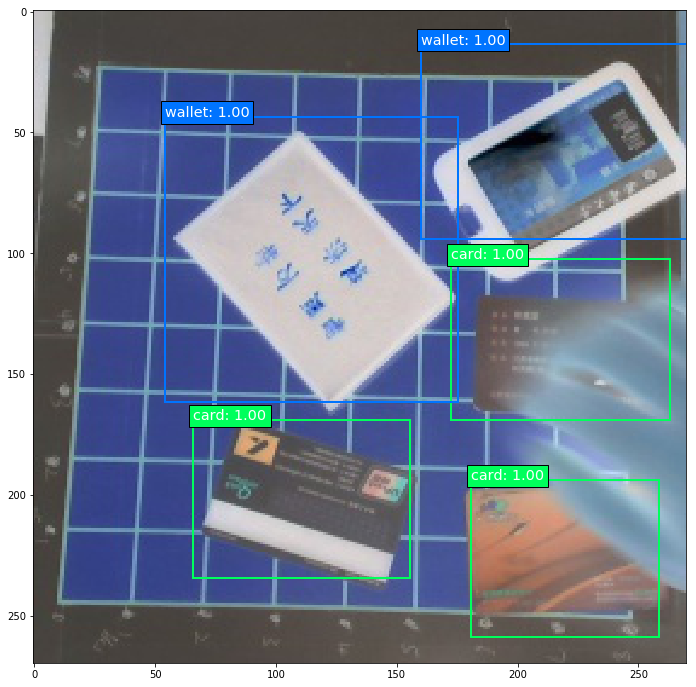

In [8]:
i = 0
plt.figure(figsize=(20,12))
plt.imshow(img1[i])
#print(img1[0])



current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # Set the colors for the bounding boxes
classes = ['background', 'remote', 'card', 'wallet', 'bottle', 'cup'] # Just so we can print class names onto the image instead of IDs

# Draw the ground truth boxes in green (omit the label for more clarity)
# for box in batch_labels[i]:
#     xmin = box[1]
#     ymin = box[2]
#     xmax = box[3]
#     ymax = box[4]
#     label = '{}'.format(classes[int(box[0])])
#     current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
#     #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# Draw the predicted boxes in blue
for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})